In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 
import matplotlib.colors as mcolors

from iminuit import Minuit

matplotlib.rcParams['text.usetex']    = True
matplotlib.rcParams['font.family']    = 'serif'
matplotlib.rcParams['font.size']      = '16'
matplotlib.rcParams['figure.figsize'] = 6.4, 4.8

code_dir = "/global/cfs/cdirs/m3166/buschman/NSaxion-master/python/"   
                                                                                    
sys.path.append(code_dir)                                                           
import theory                                                                       
from scipy.interpolate import interp1d                                              
import NScool_process as NSp 

# Load Axion spectra

In [40]:
EOS = np.array(['APR_EOS_Cat_APR_Cat_1.4', 'BSk22_test_BSk22_1.4', 'BSk24_test_BSk24_1.4', 'BSk25_test_BSk25_1.4', 'BSk26_test_BSk26_1.4'])
EOS_short = np.array(['APR', 'BSk22', 'BSk24', 'BSk25', 'BSk26']) 
SF = np.array(['0-0-0', 'SFB-0-0', 'SFB-0-T73', 'SFB-a-T73', 'SFB-b-T73', 'SFB-c-T73'])

In [3]:
def Load(eos, sf):
    APR = h5py.File('../output/' + eos +'_' +sf+'.hdf5','r')

    params = APR['params'][:]
    E_raw = APR['E'][:]
    alpha = APR['alpha'][:]

    pbf_1s0n = np.zeros((len(alpha), len(E_raw)))
    pbf_1s0p = np.zeros((len(alpha), len(E_raw)))
    pbf_3p2A = np.zeros((len(alpha), len(E_raw)))
    pbf_3p2B = np.zeros((len(alpha), len(E_raw)))
    bremsstrahlung_nn = np.zeros((len(alpha), len(E_raw)))
    bremsstrahlung_np = np.zeros((len(alpha), len(E_raw)))
    bremsstrahlung_pp = np.zeros((len(alpha), len(E_raw)))

    for i in range(len(alpha)):
        pbf_1s0n[i] = APR['1s0n_a'+str(i)][:]
        pbf_1s0p[i] = APR['1s0p_a'+str(i)][:]
        pbf_3p2A[i] = APR['3p2A_a'+str(i)][:]
        pbf_3p2B[i] = APR['3p2B_a'+str(i)][:]
        bremsstrahlung_nn[i] = APR['bremsstrahlung_nn_a'+str(i)][:]
        bremsstrahlung_np[i] = APR['bremsstrahlung_np_a'+str(i)][:]
        bremsstrahlung_pp[i] = APR['bremsstrahlung_pp_a'+str(i)][:]

    total = pbf_1s0n + pbf_1s0p + pbf_3p2A + pbf_3p2B + bremsstrahlung_nn + bremsstrahlung_np + bremsstrahlung_pp

    return E_raw, alpha, total, params[1]

all_E = []
all_alpha = []
all_total = []
all_rNS = []

for eos in EOS:
    tmp_E = []
    tmp_alpha = []
    tmp_total = []
    tmp_rNS = []
    for sf in SF:
        E, alpha, total, rNS  = Load(eos, sf)
        tmp_E.append(E)
        tmp_alpha.append(alpha)
        tmp_total.append(total)
        tmp_rNS.append(rNS)
        
    all_E.append(np.array(tmp_E))
    all_alpha.append(np.array(tmp_alpha))
    all_total.append(np.array(tmp_total))
    all_rNS.append(np.array(tmp_rNS))

all_E = np.array(all_E)
all_alpha = np.array(all_alpha)
all_total = np.array(all_total)
all_rNS = np.array(all_rNS)

## NuStar data

In [4]:
file = 'Analysis_Results.npz'
data = np.load(file)

E_NuStar = data['E']
Eval_Flux = data['Eval_Flux']
Eval_TS = data['Eval_TS']

f_ct = np.zeros(len(E_NuStar))
f_up = np.zeros(len(E_NuStar))
f_dn = np.zeros(len(E_NuStar))

for i in range(len(E_NuStar)):
    locs = np.where( Eval_TS[i,:] <= 1 )
    c = np.argmin(Eval_TS[i,:])
    f_ct[i] = Eval_Flux[i,c] * 1e-15 # erg / (cm^2 s keV)
    f_dn[i] = Eval_Flux[i,locs[0][0]] * 1e-15 # erg / (cm^2 s keV)
    f_up[i] = Eval_Flux[i,locs[0][-1]] * 1e-15 # erg / (cm^2 s keV)
    
bin_width_NuStar = np.ones(len(E_NuStar)) * 2.5
bin_width_NuStar[0] = 1
#

## PN + MOS + Chandra data

In [5]:
data1856 = np.load('1856.npz', allow_pickle=True )

f_XMM = data1856['lower']*1e-15 # erg / (cm^2 s keV)
error_low_XMM = data1856['central']*1e-15 # erg / (cm^2 s keV)
error_high_XMM = data1856['upper']*1e-15 # erg / (cm^2 s keV)

E_XMM = np.array([3,5,7])
bin_width_XMM = np.array([1,1,1])

## Combine Data

In [218]:
# Skip the first two bins of NuStar (only >= 10 keV)
SkipNustar = 2
NXMM = len(E_XMM)

E = np.empty(len(E_XMM) + len(E_NuStar) - SkipNustar)
E[:NXMM] = E_XMM
E[NXMM:] = E_NuStar[SkipNustar:]

bins_min = np.empty(len(E))
bins_max = np.empty(len(E))
bins_min[:NXMM] = E_XMM - bin_width_XMM
bins_max[:NXMM] = E_XMM + bin_width_XMM
bins_min[NXMM:] = E_NuStar[SkipNustar:] - bin_width_NuStar[SkipNustar:]
bins_max[NXMM:] = E_NuStar[SkipNustar:] + bin_width_NuStar[SkipNustar:]
dE = bins_max - bins_min
bin_width = dE

# Data flux
sig = np.empty(len(E))
sig[:NXMM] = f_XMM
sig[NXMM:] = f_ct[SkipNustar:]

# Gaussian Error
error = np.empty(len(E))
error[:NXMM] = (error_high_XMM - error_low_XMM)/2.
error[NXMM:] = (f_up[SkipNustar:] - f_dn[SkipNustar:])/2.

# truncate data
sig = sig[NXMM:]
error = error[NXMM:]
E = E[NXMM:]
dE = dE[NXMM:]
bins_max = bins_max[NXMM:]
bins_min = bins_min[NXMM:]
bin_width = bin_width[NXMM:]

## 1856 Priors

In [219]:
order=np.array(['RX J1856.5-3754'])
NSd=np.array(  [123.])
NSdd=np.array( [13.])
NSB0=np.array( [1.5e13])*0.95
NSdB0=np.array([0.1e13])
NSdB0 = np.sqrt(NSdB0**2+(0.1*NSB0)**2)
NSTeff_infty= np.array([0.050])
NSdTeff_infty= np.array([0.014])
NSdalpha = np.sqrt((NSdTeff_infty/NSTeff_infty * 4.* 0.455)**2 + 0.3**2 + (0.25* 4.* 0.455)**2)
NSdlogB0 = ( np.log10(NSB0+NSdB0) -np.log10(NSB0-NSdB0) )/2.
NSdlogalpha = ( np.log10(1+NSdalpha) -np.log10(1-NSdalpha) )/2.
Bpole = np.array([2.9])*1e13

# SN + CAST limits

In [220]:
SN1987a = np.genfromtxt('SN1987a.txt',delimiter=',')
CAST2017 = np.genfromtxt('CAST2017.txt',delimiter=',')
#print(CAST2017)
#print(CAST2017[:,0])
minCast = 10**np.min(CAST2017[2,:])*np.sqrt(3.25*10**-18/(1 + 0.29 + 0.27))#*np.sqrt(6e-19)
#print(minCast)

# Process fluxes

In [221]:
binned_flux = np.zeros((len(EOS), len(SF), len(all_alpha[0][0]), len(bins_min)))
alpha_arr = all_alpha[0][0]
for eos in range(len(EOS)):
    for sf in range(len(SF)):
        for a in range(len(alpha_arr)):
            for i in range(len(bins_min)):
                whs = np.where( ( (all_E[eos,sf]>bins_min[i]) & (all_E[eos,sf] <= bins_max[i])  ))[0]
                binned_flux[eos,sf,a,i] = np.sum(all_total[eos,sf,a][whs]*(all_E[eos,sf][1]-all_E[eos,sf][0]))/dE[i]

# Define functions needed for LL

In [222]:
## for conversion prob
alpha_EM = 1/137.
Bc = 4.41e13 #G
G_to_GeV2 = 1.95e-20 #GeV^2
cm_to_IGeV = 1/(1.98e-14)

# copied from our old code
class conv_prob:
    def __init__(self,rNS,B0,ma,gagg):
        '''
        rNS in cm
        B0 in Gauss
        ma in eV
        gagg in GeV^{-1}
        '''
        self.rNS = rNS*cm_to_IGeV #GeV^{-1}
        self.B0 = B0*G_to_GeV2 #GeV^2
        self.Bc = Bc*G_to_GeV2
        self.ma = ma*1e-9 #GeV
        self.D_M =1/2. *gagg *self.B0 # GeV
        
        #self._calc()
        
    def _calc(self,Es):
        '''
        Es in GeV
        '''
        self.x = (7*alpha_EM/45./np.pi)**(1/6.)*(Es/self.ma*self.B0/self.Bc)**(1/3.)
        self.D_a = - self.ma**2/2./Es
        self.rag = self.x*self.rNS
        
    def return_prob(self,omega):
        '''
        omega in keV
        '''
        Es = omega*1e-6 #GeV
        self._calc(Es)
        whs_0 = np.where(np.abs(self.D_a*self.rag)>0.45)[0]
        whs_1 = np.where(np.abs(self.D_a*self.rag)<0.45)[0]
        prob = np.zeros(len(omega))
        
        common = (self.D_M*self.rNS**3/self.rag**2)**2
        if len(whs_0)>0:
            prob[whs_0]= (common*(np.pi/3./np.abs(self.D_a*self.rag)) * np.exp(6./5.*self.D_a*self.rag) )[whs_0]
        if len(whs_1)>0:
            prob[whs_1]= (common*(2.21816**2/5**(6/5.)/np.abs(self.D_a*self.rag)**(4/5.))  )[whs_1]
        return prob

In [223]:
parsec2cm = 3.086e+18

# in erg/(cm^2 s keV)
def Flux(eos, sf, ma, gagg, gaNN, d, B, alpha):
    N = len(E)
    rNS = all_rNS[eos, sf] * 10. # cm
    cp = conv_prob(rNS, B, ma, gagg)
    probs = cp.return_prob(E)

    flux = np.zeros(N)
    for i in range(N):
        flux[i] = np.interp(alpha, alpha_arr, binned_flux[eos, sf, :, i])
        
    flux /= (parsec2cm * d)**2 * 4. * np.pi
    flux *= (gaNN/1e-10)**2
    flux *= probs
    
    return flux

In [224]:
def LL_gaus(Flux):
    return -(Flux-sig)**2/error**2

def return_LLNS(eos, sf, ma, gagg, d, theta, alpha):
    eos = int(eos)
    sf = int(sf)
    axion_flux = np.sign(ma) * Flux(eos=eos, sf=sf, ma=np.abs(ma), gagg=gagg, gaNN=1e-10, d=d, B=Bpole[0]*np.sin(theta), alpha=alpha)
    LL = np.sum(LL_gaus(axion_flux))
    LL += - (NSd[0] - d)**2/(2.*NSdd[0]**2) + np.log(np.sin(theta))/3. - (alpha-1.)**2/(2.*NSdalpha[0]**2)
    return -LL

# LL 

In [ ]:
Nma = 1
Ngagg = 100

ma_arr=np.logspace(-6, -1, Nma)
gagg_arr=np.logspace(-11, -5, Ngagg)

def minimize(eos, sf, ma_start, gagg_start, d_start, theta_start, alpha_start, gi, params):
    m = Minuit(return_LLNS, eos=eos, sf=sf, ma=ma_start, gagg=gagg_start, d=d_start, theta=theta_start, alpha=alpha_start)
    
    m.fixed["ma"] = True
    m.fixed["gagg"] = True
    m.fixed["eos"] = True
    m.fixed["sf"] = True
    
    m.errors["d"] = NSdd[0]
    m.errors["theta"] = 0.1
    m.errors["alpha"] = NSdalpha[0]
    
    m.limits["d"] = (60,2000)
    m.limits["theta"] = (1e-10,np.pi-1e-10)
    m.limits["alpha"] = (0.1, 5.0)
    
    m.errordef = 0.5
    
    m.migrad()
    BF_ma = m.values["ma"]
    BF_gagg = m.values["gagg"]
    BF_d = m.values["d"]
    BF_theta = m.values["theta"]
    BF_alpha = m.values["alpha"]
    LL_local = return_LLNS(eos, sf, BF_ma, BF_gagg, BF_d, BF_theta, BF_alpha)
    
    if LL_local < params[gi,-1] or params[gi, -1] == 0:
        params[gi] = np.array([BF_ma, BF_gagg ,BF_d, BF_theta ,BF_alpha, LL_local])

In [ ]:
all_params = []
eos = 3
sf = 0

for mi in range(Nma):
    params = np.zeros((Ngagg, 6))
    for gi in range(Ngagg):
        if gi%25 == 0:
            print(gi)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0],        np.pi/2.,    1.0,            gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0],        np.pi/2.,    1.0+NSdalpha[0],gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0],        np.pi/2.,    1.0-NSdalpha[0],gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0],        np.pi/2.-0.2,1.0,            gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0],        np.pi/2.-0.5,1.0,            gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0]+NSdd[0],np.pi/2.,    1.0,            gi, params)
        minimize(eos, sf, ma_arr[mi], gagg_arr[gi], NSd[0]-NSdd[0],np.pi/2.,    1.0,            gi, params)
    all_params.append(params)

In [ ]:
mi = 0

LL = all_params[mi][:,-1]
TS = 2.*(LL - np.min(LL))
plt.plot(gagg_arr, TS, marker='.')
plt.xscale('log')
plt.ylim(0,9)
plt.axhline(1)
plt.axhline(2.75)
plt.axhline(4)


BFi = np.argmin(TS)
print(BFi)

BF_eos = eos
BF_sf = sf
BF_ma = ma_arr[mi]
BF_gagg = gagg_arr[BFi]
BF_d = all_params[mi][BFi,2]
BF_theta = all_params[mi][BFi,3]
BF_alpha = all_params[mi][BFi,4]
print(BF_eos, BF_sf, BF_ma, BF_gagg, BF_d, BF_theta, BF_alpha)

# Plot

In [ ]:
axion_flux = np.sign(BF_ma) * Flux(eos=BF_eos, sf=BF_sf, ma=np.abs(BF_ma), gagg=BF_gagg, 
                                   gaNN=1e-10, d=BF_d, B=Bpole[0]*np.sin(BF_theta), alpha=BF_alpha)

hist_axion_flux = np.zeros(len(axion_flux)*2)
hist_axion_flux[::2] = axion_flux
hist_axion_flux[1::2] = axion_flux
hist_axion_E = np.zeros(len(axion_flux)*2)
hist_axion_E[::2] = bins_min
hist_axion_E[1::2] = bins_max

In [ ]:
X0 = 0
X1 = 9
X2 = 60
ratio = (X2-X1)/(X1-X0)

fig, ax = plt.subplots(figsize=(12,4), ncols=2, width_ratios=[1,ratio], layout="constrained")

ax[0].axhline(0, color='lightgray')
ax[0].errorbar(E[:NXMM], sig[:NXMM], xerr=[bin_width[:NXMM]/2., bin_width[:NXMM]/2.], yerr=error[:NXMM],
              linewidth=0, elinewidth=1, capsize=3, color='black', fmt = 's', capthick=1, markersize=1)
ax[0].plot(hist_axion_E[:NXMM*2], hist_axion_flux[:NXMM*2], color='black')

ax[0].set_xlim(X0,X1)
ax[0].set_ylim(-2e-15, 2e-15) 
ax[0].set_xticks([0, 5])
ax[0].text(0.5, 1.22e-15,'PN+\nMOS+\nChandra', fontsize=14)

ax[1].axhline(0, color='lightgray')
ax[1].errorbar(E[NXMM:], sig[NXMM:], xerr=[bin_width[NXMM:]/2., bin_width[NXMM:]/2.], yerr=error[NXMM:],
              linewidth=0, elinewidth=1, capsize=3, color='black', fmt = 's', capthick=1, markersize=1, label='Data')
ax[1].plot(hist_axion_E[NXMM*2:], hist_axion_flux[NXMM*2:], color='black', label='Axion model')
ax[1].set_xlim(X1, X2)
ax[1].set_ylim(-4e-14, 4e-14) 
ax[1].text(9.5, 3.4e-14,'NuStar', fontsize=14)
ax[1].yaxis.tick_right()
ax[1].set_xticks(np.linspace(10,60,50//5+1))

ax[1].set_xlabel('$E$ [keV]',fontsize=18)
ax[0].set_ylabel('$dF/dE$ [erg/cm$^2$/s/keV]',fontsize=18)
ax[1].set_ylabel('$dF/dE$ [erg/cm$^2$/s/keV]',fontsize=18)
ax[1].yaxis.set_label_position("right")
ax[0].axvline(X1, linewidth=2, color='black')

ax[1].legend()
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(axis="y" ,direction="in")
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis="y" ,direction="in")

#ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis="x" ,direction="in")
#ax[1].xaxis.set_ticks_position('both')
ax[1].tick_params(axis="x" ,direction="in")

fig.get_layout_engine().set(wspace=0, hspace=0, w_pad=0, h_pad=0)

# From scan

In [225]:
all_params = []
for eos in range(len(EOS)):
    tmp_params = []
    for sf in range(len(SF)):
        fin = h5py.File('../scan/results/eom_'+str(eos)+'_'+str(sf)+'.h5','r')
        par = fin['data'][:]
        tmp_params.append(par)
        fin.close()
    all_params.append( np.array(tmp_params) )
all_params = np.array(all_params)

In [226]:
np.shape(all_params)

(5, 6, 1, 200, 200, 6)

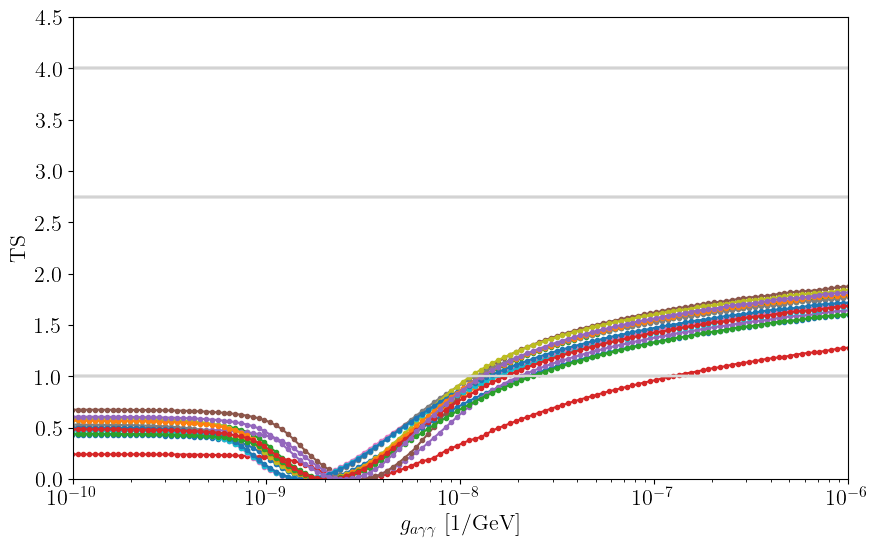

In [275]:
fig, ax = plt.subplots(figsize=(10,6))

mi = 0
Nm = len(all_params[0, 0, 0, 0, :, 0])
Ng = len(all_params[0, 0, 0, 0, :, 1])

BFs = np.empty((len(EOS), len(SF), Nm, 6))
TSs_local = np.empty((len(EOS), len(SF), Nm, Ng))
TSs_global = np.empty((len(EOS), len(SF), Nm, Ng))
           
for eos in range(len(EOS)):
    for sf in [0,1,2]:#range(len(SF)):
        LLmin_global = np.min(all_params[eos, sf, 0, :, :, -1])
        for mi in range(Nm):
            LL = all_params[eos, sf, 0, mi, :, -1]
            ma_arr = all_params[eos, sf, 0, mi, :, 0]
            gagg_arr = all_params[eos, sf, 0, mi, :, 1]
            TS_local = 2.*(LL - np.min(LL))
            TS_global = 2.*(LL - LLmin_global)

            TS95 = gagg_arr[np.where(TS_local < 2.75)[0][-1]]

            if mi == 0:
                plt.plot(gagg_arr, TS_local, marker='.')
                plt.xscale('log')
                plt.ylim(0,4.5)
                plt.xlim(1e-10, 1e-6)
                plt.axhline(1, color='lightgray')
                plt.axhline(2.75, color='lightgray')
                plt.axhline(4, color='lightgray')
                plt.xlabel(r'$g_{a\gamma\gamma}$ [1/GeV]')
                plt.ylabel(r'TS')

            BFi = np.argmin(TS_local)
            BF_ma = ma_arr[mi]
            BF_gagg = gagg_arr[BFi]
            BF_d = all_params[eos, sf, 0, mi, BFi,2]
            BF_theta = all_params[eos, sf, 0, mi, BFi,3]
            BF_alpha = all_params[eos, sf, 0, mi, BFi,4]
            BFs[eos, sf, mi] = np.array([BF_ma, BF_gagg, BF_d, BF_theta, BF_alpha, TS95])
            TSs_local[eos, sf, mi] = TS_local
            TSs_global[eos, sf, mi] = TS_global
        #print(BF_eos, BF_sf, BF_ma, BF_gagg, BF_d, BF_theta, BF_alpha)

In [228]:
hist_axion_flux = np.empty((len(EOS), len(SF), len(E)*2))
hist_axion_E = np.empty((len(EOS), len(SF), len(E)*2))

for eos in range(len(EOS)):
    for sf in range(len(SF)):
        BF = BFs[eos, sf, 0]
        axion_flux = np.sign(BF[0]) * Flux(eos=eos, sf=sf, ma=np.abs(BF[0]), gagg=BF[1], 
                                           gaNN=1e-10, d=BF[2], B=Bpole[0]*np.sin(BF[3]), 
                                           alpha=BF[4])

        hist_axion_flux[eos,sf,::2] = axion_flux
        hist_axion_flux[eos,sf,1::2] = axion_flux
        hist_axion_E[eos,sf,::2] = bins_min
        hist_axion_E[eos,sf,1::2] = bins_max

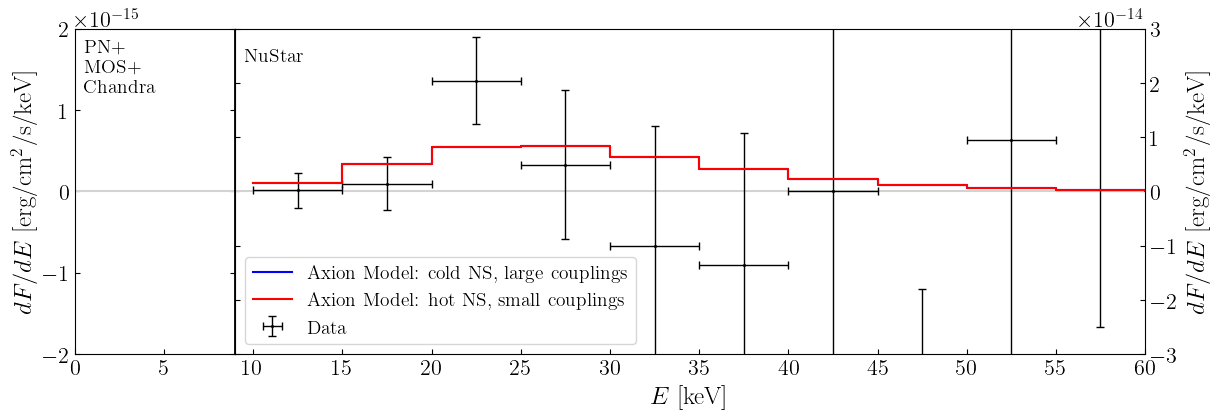

In [268]:
X0 = 0
X1 = 9
X2 = 60
NXMM=0
ratio = (X2-X1)/(X1-X0)

fig, ax = plt.subplots(figsize=(12,4), ncols=2, width_ratios=[1,ratio], layout="constrained")

ax[0].axhline(0, color='lightgray')
ax[0].errorbar(E[:NXMM], sig[:NXMM], xerr=[bin_width[:NXMM]/2., bin_width[:NXMM]/2.], yerr=error[:NXMM],
              linewidth=0, elinewidth=1, capsize=3, color='black', fmt = 's', capthick=1, markersize=1)
#for eos in range(len(EOS)):
#    for sf in range(len(SF)):
#        ax[0].plot(hist_axion_E[eos, sf, :NXMM*2], hist_axion_flux[eos, sf, :NXMM*2], color='red')
eos1 = 4
sf1 = 3
ax[0].plot(hist_axion_E[eos1, sf1, :NXMM*2], hist_axion_flux[eos1, sf1, :NXMM*2], color='blue')
ax[0].plot(hist_axion_E[eos1, sf1, :NXMM*2], hist_axion_flux[eos1, sf1, :NXMM*2], color='red')

ax[0].set_xlim(X0,X1)
ax[0].set_ylim(-2e-15, 2e-15) 
ax[0].set_xticks([0, 5])
ax[0].text(0.5, 1.22e-15,'PN+\nMOS+\nChandra', fontsize=14)

ax[1].axhline(0, color='lightgray')
ax[1].errorbar(E[NXMM:], sig[NXMM:], xerr=[bin_width[NXMM:]/2., bin_width[NXMM:]/2.], yerr=error[NXMM:],
              linewidth=0, elinewidth=1, capsize=3, color='black', fmt = 's', capthick=1, markersize=1, label='Data')
#for eos in range(len(EOS)):
#    for sf in range(len(SF)):
#        ax[1].plot(hist_axion_E[eos, sf, NXMM*2:], hist_axion_flux[eos, sf, NXMM*2:], color='red')

ax[1].plot(hist_axion_E[eos1, sf1, NXMM*2:], hist_axion_flux[eos1, sf1, NXMM*2:], color='blue', label='Axion Model: cold NS, large couplings')
ax[1].plot(hist_axion_E[eos1, sf1, NXMM*2:], hist_axion_flux[eos1, sf1, NXMM*2:], color='red', label='Axion Model: hot NS, small couplings')


ax[1].set_xlim(X1, X2)
ax[1].set_ylim(-3e-14, 3e-14) 
ax[1].text(9.5, 2.4e-14,'NuStar', fontsize=14)
ax[1].yaxis.tick_right()
ax[1].set_xticks(np.linspace(10,60,50//5+1))

ax[1].set_xlabel('$E$ [keV]',fontsize=18)
ax[0].set_ylabel('$dF/dE$ [erg/cm$^2$/s/keV]',fontsize=18)
ax[1].set_ylabel('$dF/dE$ [erg/cm$^2$/s/keV]',fontsize=18)
ax[1].yaxis.set_label_position("right")
ax[0].axvline(X1, linewidth=2, color='black')

ax[1].legend(loc='lower left', fontsize = 14)
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(axis="y" ,direction="in")
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(axis="y" ,direction="in")

#ax[0].xaxis.set_ticks_position('both')
ax[0].tick_params(axis="x" ,direction="in")
#ax[1].xaxis.set_ticks_position('both')
ax[1].tick_params(axis="x" ,direction="in")

fig.get_layout_engine().set(wspace=0, hspace=0, w_pad=0, h_pad=0)

In [231]:
sig/error

array([ 0.05405405,  0.28571429,  2.53846154,  0.35714286, -0.4516129 ,
       -0.56      ,  0.        , -1.41666667,  0.17391304,  0.63636364,
       -2.45454545, -1.47826087,  1.04347826, -0.2       ])

(1e-20, 1e-15)

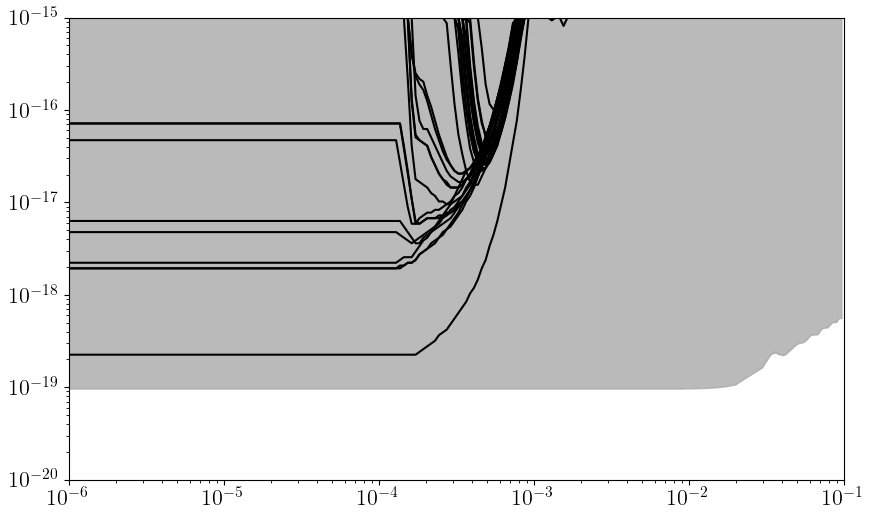

In [273]:
fig, ax = plt.subplots(figsize=(10,6))

gaNN = 1e-10
for eos in range(len(EOS)):
    for sf in range(len(SF)):
        plt.plot(BFs[eos, sf, :, 0], BFs[eos, sf, :, -1]*gaNN, color='black')
        
plt.fill_between(10**np.append(-12,CAST2017[:,0])*1,10**np.append(CAST2017[0,1],CAST2017[:,1])*np.sqrt(3.25*10**-18/(1 + 0.29 + 0.27)),
            [1]*(len(CAST2017[:,0])+1), color='Darkgray',alpha=0.8)        

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1e-1)
plt.ylim(1e-20, 1e-15)

In [270]:
TS_1sigma = np.zeros_like(TSs_global)
TS_1sigma[np.where(TSs_global <= 1)] = 1

TS_sigma = np.zeros_like(TSs_global)
#TS_sigma[np.where(TSs_global <= 4)] = 4
TS_sigma[np.where(TSs_global <= 1)] = 1

Text(0, 0.5, '$g_{a\\gamma\\gamma}g_{ann}$ [1/GeV]')

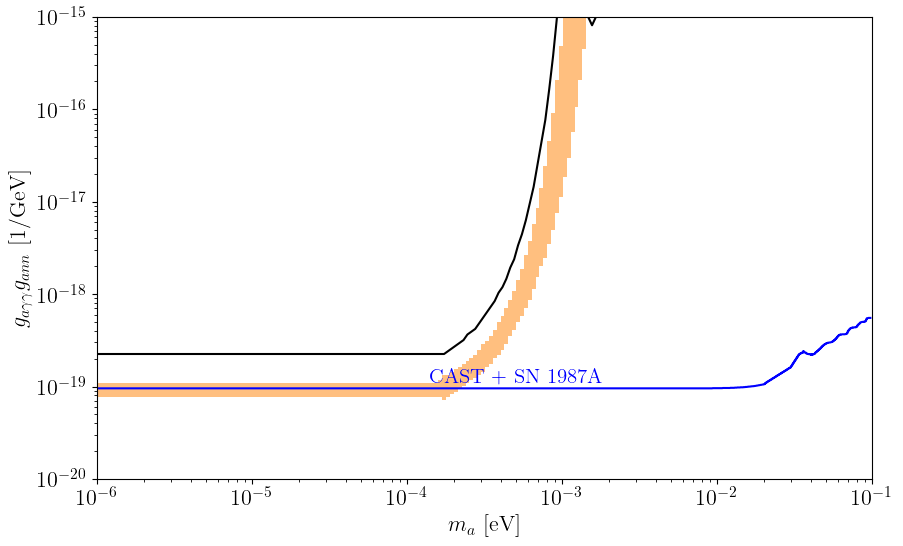

In [271]:
eos = 4
sf = 3

ma_arr = BFs[eos, sf, :, 0]
gaNN = 1e-10
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(10**np.append(-12,CAST2017[:,0])*1, 10**np.append(CAST2017[0,1],CAST2017[:,1])*np.sqrt(3.25*10**-18/(1 + 0.29 + 0.27)), 
         color='blue',alpha=1) 
plt.text(1.4e-4 ,1.1e-19,'CAST + SN 1987A',fontsize=15,color='blue')

plt.plot(BFs[eos, sf, :, 0], BFs[eos, sf, :, -1]*gaNN, color='black')
im = plt.pcolormesh(ma_arr, gagg_arr*gaNN, TS_sigma[eos, sf].T, cmap='gist_heat_r', vmin = -0, vmax=8) 
#cb = fig.colorbar(im, ax=ax)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1e-1)
plt.ylim(1e-20, 1e-15)
plt.xlabel(r'$m_a$ [eV]')
plt.ylabel(r'$g_{a\gamma\gamma}g_{ann}$ [1/GeV]')

1e-06


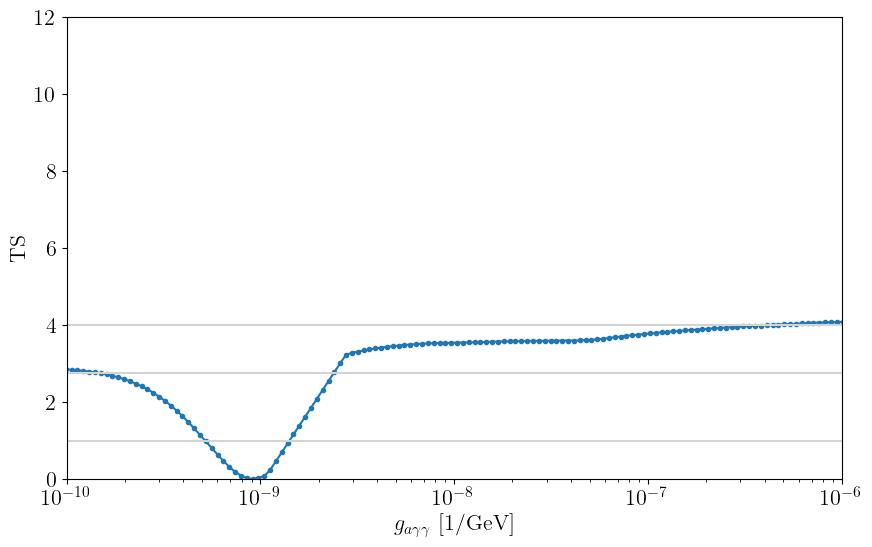

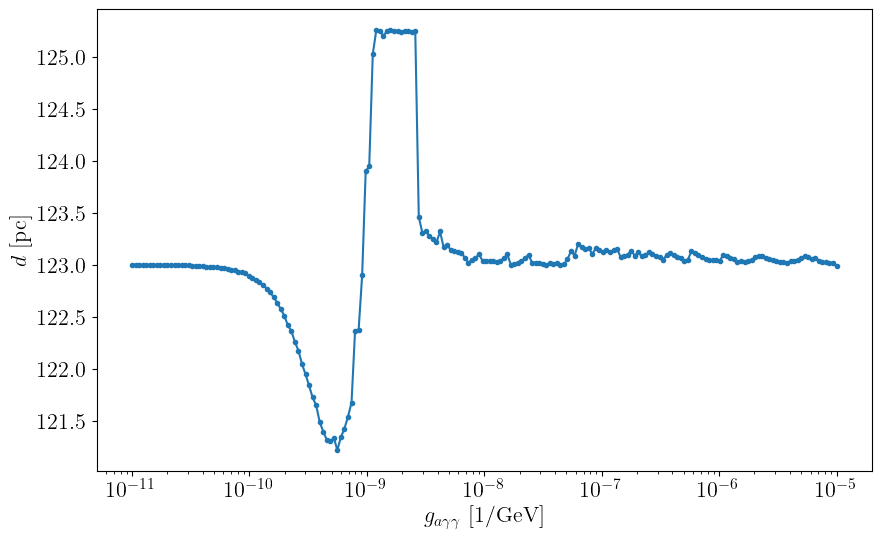

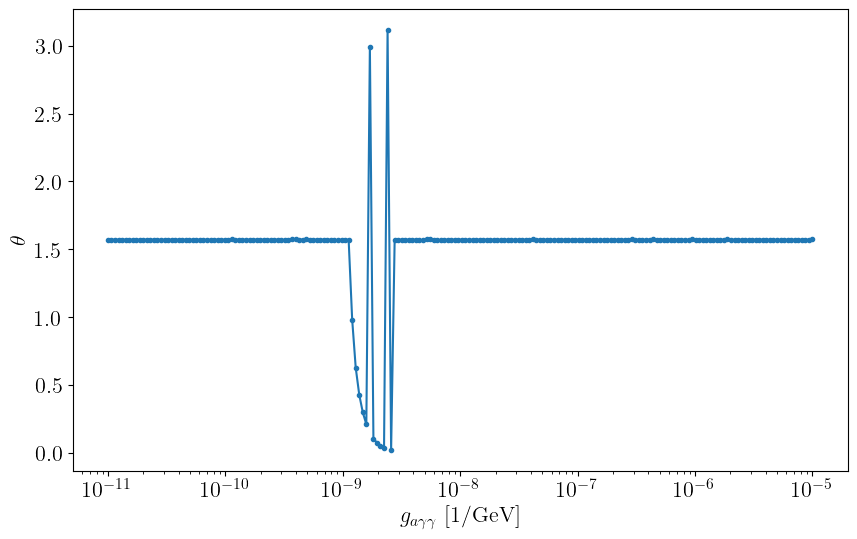

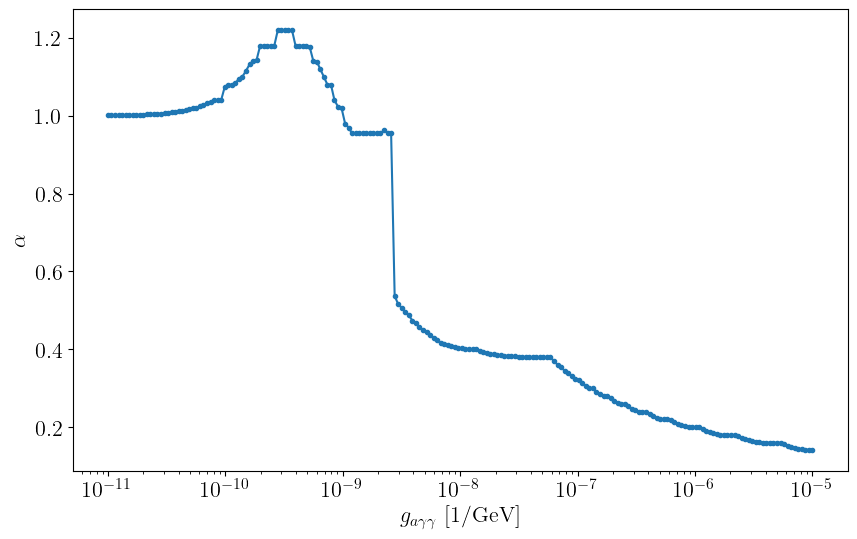

In [269]:


mi = 0
Nm = len(all_params[0, 0, 0, 0, :, 0])
Ng = len(all_params[0, 0, 0, 0, :, 1])
          
for eos in [4]:
    for sf in [3]:
        LLmin_global = np.min(all_params[eos, sf, 0, :, :, -1])
        for mi in [0]:
            LL = all_params[eos, sf, 0, mi, :, -1]
            ma_arr = all_params[eos, sf, 0, mi, :, 0]
            print(ma_arr[mi])
            gagg_arr = all_params[eos, sf, 0, mi, :, 1]
            TS_local = 2.*(LL - np.min(LL))
            TS_global = 2.*(LL - LLmin_global)

            TS95 = gagg_arr[np.where(TS_local < 2.75)[0][-1]]

            fig, ax = plt.subplots(figsize=(10,6))
            plt.plot(gagg_arr, TS_local, marker='.')
            plt.xscale('log')
            plt.ylim(0,12)
            plt.xlim(1e-10, 1e-6)
            plt.axhline(1, color='lightgray')
            plt.axhline(2.75, color='lightgray')
            plt.axhline(4, color='lightgray')
            plt.xlabel(r'$g_{a\gamma\gamma}$ [1/GeV]')
            plt.ylabel(r'TS')
            
            
            fig, ax = plt.subplots(figsize=(10,6))
            plt.plot(gagg_arr, all_params[eos, sf, 0, mi, :, 2], marker='.')
            plt.xscale('log')
            plt.xlabel(r'$g_{a\gamma\gamma}$ [1/GeV]')
            plt.ylabel(r'$d$ [pc]')
            
            
            fig, ax = plt.subplots(figsize=(10,6))
            plt.plot(gagg_arr, all_params[eos, sf, 0, mi, :, 3], marker='.')
            plt.xscale('log')
            plt.xlabel(r'$g_{a\gamma\gamma}$ [1/GeV]')
            plt.ylabel(r'$\theta$')
            
            
            fig, ax = plt.subplots(figsize=(10,6))
            plt.plot(gagg_arr, all_params[eos, sf, 0, mi, :, 4], marker='.')
            plt.xscale('log')
            plt.xlabel(r'$g_{a\gamma\gamma}$ [1/GeV]')
            plt.ylabel(r'$\alpha$')